In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)  # Figure size for inline display
import numpy as np
from scipy.fftpack import ifftshift, fftshift, fft2
import warnings
warnings.filterwarnings('ignore')

from pynx.utils.pattern import siemens_star

# This will import the base CDI class and all relevant operators, in CUDA (default) or OpenCL
from pynx.cdi import *

if False:
    # The following is only using on multi-GPU, multi-user (e.g. Amazon) machines
    # Select a device number (0..15) to avoid resource conflict with other participants
    from pynx.processing_unit.cuda_device import has_cuda
    if has_cuda: # use cuda
        from pynx.cdi.cu_operator import default_processing_unit_cdi
        from pynx.processing_unit.cuda_device import cu_drv
        default_processing_unit_cdi.init_cuda(cu_device=cu_drv.Device(0))   # Change this to you GPU number
    else:
        import pyopencl as cl
        from pynx.cdi.cl_operator import default_processing_unit_cdi
        # Only needed on Amazon to select one of multiple GPU
        cl_devices=cl.get_platforms()[1].get_devices()
        default_processing_unit_cdi.init_cl(cl_device=cl_devices[0])   # Change this to you GPU number

gpyfft version: 0.7.0


In [2]:
# Test on a simulated pattern (2D)
n = 512

# Siemens-Star object
obj0 = siemens_star(n, nb_rays=18, r_max=60, nb_rings=3)

iobs = abs(ifftshift(fft2(fftshift(obj0.astype(np.complex64))))) ** 2
iobs = np.random.poisson(iobs * 1e10 / iobs.sum())
mask = np.zeros_like(iobs)

In [3]:
# Create CDI object, make sure it is fft-shifted
cdi = CDI(fftshift(iobs), obj=None, support=None, mask=mask, pixel_size_detector=55e-6, detector_distance=1, wavelength=1.5e-10)

In [4]:
# Use auto-correlation to estimate the initial support
%matplotlib inline
from pylab import imshow, figure
cdi = AutoCorrelationSupport(0.2) * cdi
# restrict initial object to calculated support
cdi.set_obj(cdi.get_obj() * cdi.get_support())

Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                                            Iris Pro [Apple]: 1536Mb [max alloc.: 384Mb],  13.13 Gflop/s
                  AMD Radeon R9 M370X Compute Engine [Apple]: 2048Mb [max alloc.: 512Mb],  80.79 Gflop/s
Using OpenCL GPU: AMD Radeon R9 M370X Compute Engine
CDI OpenCL processing unit: compiling kernels...
CDI OpenCL processing unit: compiling kernels... Finished (dt= 0.89s)


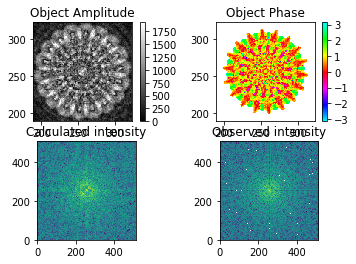

In [5]:
%matplotlib inline
# Do 100 cycles of RAAR, displaying object at the end
cdi = ShowCDI() * RAAR()**100 * cdi

<IPython.core.display.Javascript object>


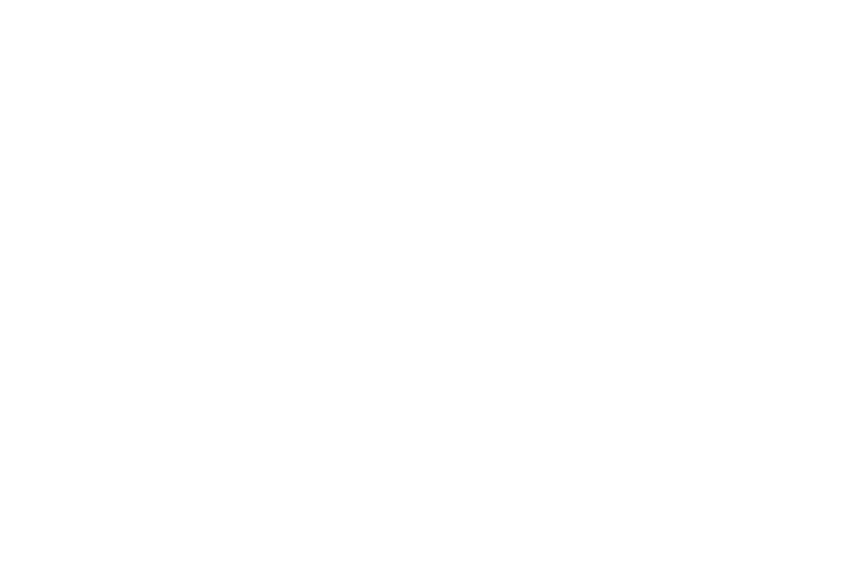

Nb points in support: 9187 ( 3.505%), threshold=528.668274  ( 0.400), nb photons=1.604797e+10
LLK/nbpoint = 105390.090
Nb points in support: 13321 ( 5.082%), threshold=350.148590  ( 0.400), nb photons=1.020755e+10
LLK/nbpoint = 3770.617
Nb points in support: 11870 ( 4.528%), threshold=374.667328  ( 0.400), nb photons=1.041411e+10
LLK/nbpoint = 7170.760
Nb points in support: 11271 ( 4.300%), threshold=384.242554  ( 0.400), nb photons=1.040048e+10
LLK/nbpoint = 7100.281
Nb points in support: 10801 ( 4.120%), threshold=393.968079  ( 0.400), nb photons=1.047770e+10
LLK/nbpoint = 8554.064
Nb points in support: 10504 ( 4.007%), threshold=398.374634  ( 0.400), nb photons=1.041881e+10
LLK/nbpoint = 7558.000
Nb points in support: 9619 ( 3.669%), threshold=416.581604  ( 0.400), nb photons=1.043302e+10
LLK/nbpoint = 7781.222
Nb points in support: 8398 ( 3.204%), threshold=439.466797  ( 0.400), nb photons=1.013697e+10
LLK/nbpoint = 2309.802
Nb points in support: 5589 ( 2.132%), threshold=535.40521

<IPython.core.display.Javascript object>


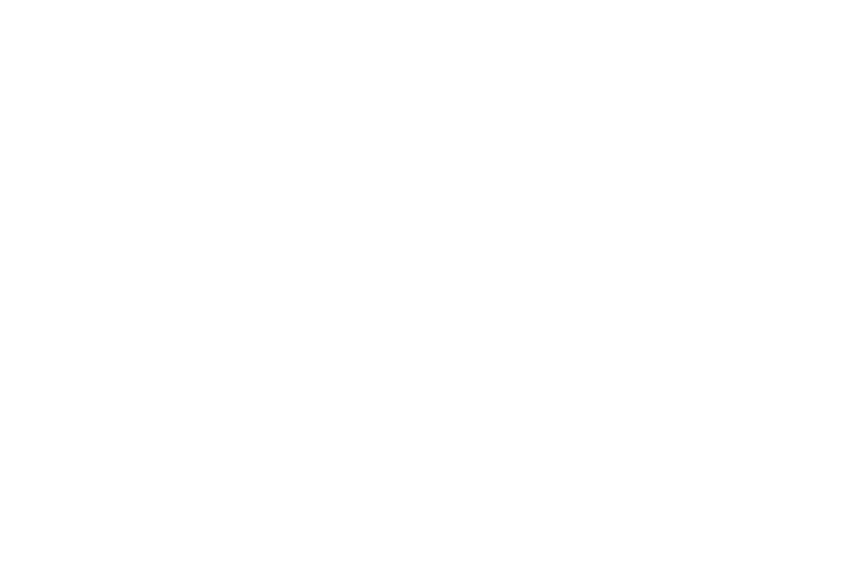

In [6]:
# Activate live display
%matplotlib notebook
for i in range(10):
    # Support update operator
    s = 0.25+1.75*np.exp(-i/4)
    sup = SupportUpdate(threshold_relative=0.4, smooth_width=s, force_shrink=False)

    # Do 40 cycles of HIO or RAAR, displaying object every 20 cycle
    cdi = (ShowCDI(fig_num=1) * RAAR() ** 20) ** 2 * cdi

    # Update support
    cdi = ShowCDI(fig_num=1) * sup * cdi

    IFT() * LLK() * FT() * cdi
    print("LLK/nbpoint = %8.3f" % ((cdi.llk - cdi._llk_offset) / cdi._llk_norm))


# Do 100 cycles of ER, displaying object at the end
cdi = ShowCDI(fig_num=1) * ER() ** 20 * cdi

IFT() * LLK() * FT() * cdi
print("LLK/nbpoint = %8.3f" % ((cdi.llk - cdi._llk_offset) / cdi._llk_norm))


# Do 20 cycles of ML, displaying object every 20 cycle
cdi = ShowCDI(fig_num=1) * ML(reg_fac=1e-2)**20 * cdi


IFT() * LLK() * FT() * cdi
print("LLK/nbpoint = %8.3f" % ((cdi.llk - cdi._llk_offset) / cdi._llk_norm))


In [7]:
print(2 * ER() * 2j * ImshowRGBA())
print(2+ER())

2*ERProj()*IFT()*ApplyAmplitude()*FT()*2j*ImshowRGBA()
ERProj()*IFT()*ApplyAmplitude()*FT()+Scale()


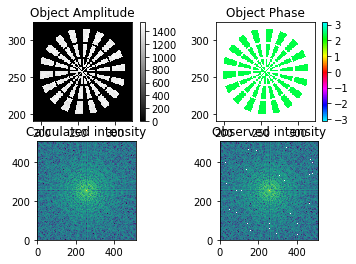

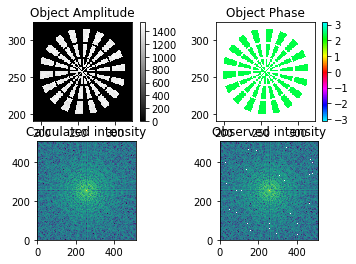

In [8]:
%matplotlib inline
ShowCDI() * FreePU() * cdi
ShowCDI() * (1-ER()-1)**100 *cdi